In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import preprocessing
from GGLasso.gglasso.problem import glasso_problem
from utils import transform_features, scale_array_by_diagonal
from utils import PCA

# Data

## Raw data

In [2]:
raw = pd.read_csv('data/composition_feature-table.tsv', sep='\t', index_col = 0)

print(raw.shape)
raw.head()

(130, 53)


,BAQ2420.1.1,BAQ2420.1.2,BAQ2420.1.3,BAQ2420.2,BAQ2420.3,BAQ2462.1,BAQ2462.2,BAQ2462.3,BAQ2687.1,BAQ2687.2,...,YUN3533.1.1,YUN3533.1.2,YUN3533.1.3,YUN3533.2,YUN3533.3,YUN3856.1.1,YUN3856.1.2,YUN3856.1.3,YUN3856.2,YUN3856.3
#OTU ID,,,,,,,,,,,,,,,,,,,,,
409faa5f5353e543bf6d99125c7c0e83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,102.0,181.0,65.0,109.0,0.0,597.0,0.0,129.0,0.0
1237d5925a7176fced9dda961a86c684,0.0,0.0,9.0,92.0,0.0,86.0,57.0,0.0,0.0,0.0,...,0.0,0.0,76.0,958.0,97.0,0.0,0.0,0.0,0.0,0.0
a7b877ae6d2f079a15b6b192a4425620,0.0,0.0,0.0,40.0,50.0,46.0,24.0,69.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0
ef3fdbe1dcde754d91130cde6a4b4d61,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,44.0,0.0,83.0,0.0,0.0,0.0,80.0,0.0
96cbccca68ad868a78bb0604e4a41cf5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,39.0,34.0,77.0,55.0,0.0,0.0,0.0,0.0,0.0


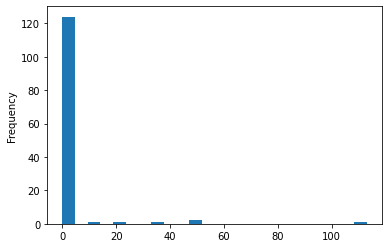

In [3]:
# raw.to_csv("data/count_table.csv", index=True)
raw.iloc[:, 0].plot.hist(bins=24, alpha=1).get_figure().savefig('plots/raw_count.png')

## CLR

In [4]:
clr = transform_features(raw, transformation="clr")
clr.head()

,BAQ2420.1.1,BAQ2420.1.2,BAQ2420.1.3,BAQ2420.2,BAQ2420.3,BAQ2462.1,BAQ2462.2,BAQ2462.3,BAQ2687.1,BAQ2687.2,...,YUN3533.1.1,YUN3533.1.2,YUN3533.1.3,YUN3533.2,YUN3533.3,YUN3856.1.1,YUN3856.1.2,YUN3856.1.3,YUN3856.2,YUN3856.3
#OTU ID,,,,,,,,,,,,,,,,,,,,,
409faa5f5353e543bf6d99125c7c0e83,-0.16777,-0.436407,-0.229753,-0.424645,-0.353991,-0.384811,-0.393926,-0.290604,-0.481342,-0.250646,...,-0.179792,4.270642,4.797162,3.655617,4.162278,-0.213116,5.902041,-0.328879,4.448310,-0.578382
1237d5925a7176fced9dda961a86c684,-0.16777,-0.436407,1.967471,4.097143,-0.353991,4.069537,3.649126,-0.290604,-0.481342,-0.250646,...,-0.179792,-0.354331,3.929399,6.346077,4.045641,-0.213116,-0.489876,-0.328879,-0.411502,-0.578382
a7b877ae6d2f079a15b6b192a4425620,-0.16777,-0.436407,-0.229753,3.264234,3.558032,3.443831,2.784128,3.943502,-0.481342,-0.250646,...,-0.179792,-0.354331,-0.401335,-0.518771,-0.529070,-0.213116,-0.489876,2.889997,-0.411502,-0.578382
ef3fdbe1dcde754d91130cde6a4b4d61,-0.16777,2.782469,-0.229753,-0.424645,-0.353991,-0.384811,-0.393926,-0.290604,-0.481342,-0.250646,...,-0.179792,-0.354331,3.382855,-0.518771,3.889770,-0.213116,-0.489876,-0.328879,3.970525,-0.578382
96cbccca68ad868a78bb0604e4a41cf5,-0.16777,-0.436407,-0.229753,-0.424645,-0.353991,-0.384811,-0.393926,-0.290604,-0.481342,-0.250646,...,-0.179792,3.309231,3.125026,3.825035,3.478263,-0.213116,-0.489876,-0.328879,-0.411502,-0.578382


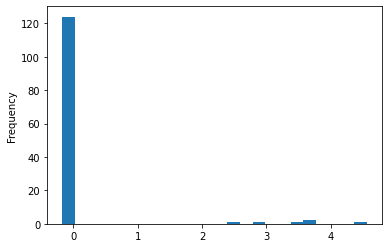

In [5]:
clr.iloc[:, 0].plot.hist(bins=24, alpha=1).get_figure().savefig('plots/clr_count.png')

## Modified CLR

In [6]:
mclr = transform_features(raw, transformation="mclr")
mclr.head()

,BAQ2420.1.1,BAQ2420.1.2,BAQ2420.1.3,BAQ2420.2,BAQ2420.3,BAQ2462.1,BAQ2462.2,BAQ2462.3,BAQ2687.1,BAQ2687.2,...,YUN3533.1.1,YUN3533.1.2,YUN3533.1.3,YUN3533.2,YUN3533.3,YUN3856.1.1,YUN3856.1.2,YUN3856.1.3,YUN3856.2,YUN3856.3
#OTU ID,,,,,,,,,,,,,,,,,,,,,
409faa5f5353e543bf6d99125c7c0e83,0.510611,0.241975,0.448628,0.253736,0.324391,0.293571,0.284456,0.387777,0.19704,0.427736,...,0.49859,4.949024,5.475544,4.333998,4.840660,0.465266,6.580423,0.349503,5.126692,0.1
1237d5925a7176fced9dda961a86c684,0.510611,0.241975,2.645853,4.775525,0.324391,4.747918,4.327508,0.387777,0.19704,0.427736,...,0.49859,0.324051,4.607780,7.024459,4.724023,0.465266,0.188506,0.349503,0.266880,0.1
a7b877ae6d2f079a15b6b192a4425620,0.510611,0.241975,0.448628,3.942616,4.236414,4.122212,3.462510,4.621884,0.19704,0.427736,...,0.49859,0.324051,0.277047,0.159611,0.149312,0.465266,0.188506,3.568379,0.266880,0.1
ef3fdbe1dcde754d91130cde6a4b4d61,0.510611,3.460851,0.448628,0.253736,0.324391,0.293571,0.284456,0.387777,0.19704,0.427736,...,0.49859,0.324051,4.061237,0.159611,4.568152,0.465266,0.188506,0.349503,4.648906,0.1
96cbccca68ad868a78bb0604e4a41cf5,0.510611,0.241975,0.448628,0.253736,0.324391,0.293571,0.284456,0.387777,0.19704,0.427736,...,0.49859,3.987612,3.803408,4.503417,4.156645,0.465266,0.188506,0.349503,0.266880,0.1


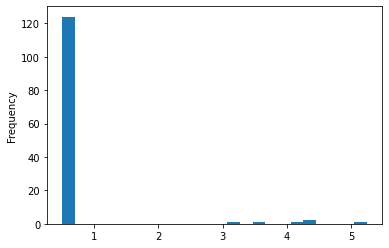

In [7]:
mclr.iloc[:, 0].plot.hist(bins=24, alpha=1).get_figure().savefig('plots/mclr_count.png')

## Covariates

In [8]:
# covariates
meta = pd.read_csv('data/acm_meta.tsv', sep='\t', index_col = 0)

# select only numeric features
meta = meta.loc[:, meta.iloc[0, :] != 'categorical']
meta = meta.apply(pd.to_numeric, errors='coerce')

# drop QIIME2 header
meta = meta.iloc[1:]
# fill missing values with zeros
meta = meta.fillna(0)

print(meta.shape)
meta.head()

(75, 15)


,elevation,extract-concen,amplicon-concentration,depth,ph,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
sample-id,,,,,,,,,,,,,,,
BAQ1370.1.2,1370.0,0.019,0.95,2.0,7.98,525.0,6.080,16.17,23.97,11.42,0.0,22.61,35.21,12.46,0.0
BAQ1370.3,1370.0,0.124,17.46,2.0,0.00,771.0,6.080,16.17,23.97,11.42,0.0,22.61,35.21,12.46,0.0
BAQ1370.1.3,1370.0,1.200,0.96,3.0,8.13,0.0,0.000,16.17,23.97,11.42,0.0,22.61,35.21,12.46,0.0
BAQ1552.1.1,1552.0,0.722,18.83,1.0,7.87,0.0,0.000,15.75,35.36,11.10,0.0,22.63,30.65,10.96,0.0
BAQ1552.2,1552.0,0.017,2.00,2.0,0.00,223.0,1.839,15.75,35.36,11.10,0.0,22.63,30.65,10.96,0.0


array([<AxesSubplot:title={'center':'elevation'}>,
       <AxesSubplot:title={'center':'extract-concen'}>,
       <AxesSubplot:title={'center':'amplicon-concentration'}>,
       <AxesSubplot:title={'center':'depth'}>,
       <AxesSubplot:title={'center':'ph'}>,
       <AxesSubplot:title={'center':'toc'}>,
       <AxesSubplot:title={'center':'ec'}>,
       <AxesSubplot:title={'center':'average-soil-relative-humidity'}>,
       <AxesSubplot:title={'center':'relative-humidity-soil-high'}>,
       <AxesSubplot:title={'center':'relative-humidity-soil-low'}>,
       <AxesSubplot:title={'center':'percent-relative-humidity-soil-100'}>,
       <AxesSubplot:title={'center':'average-soil-temperature'}>,
       <AxesSubplot:title={'center':'temperature-soil-high'}>,
       <AxesSubplot:title={'center':'temperature-soil-low'}>,
       <AxesSubplot:title={'center':'percentcover'}>], dtype=object)

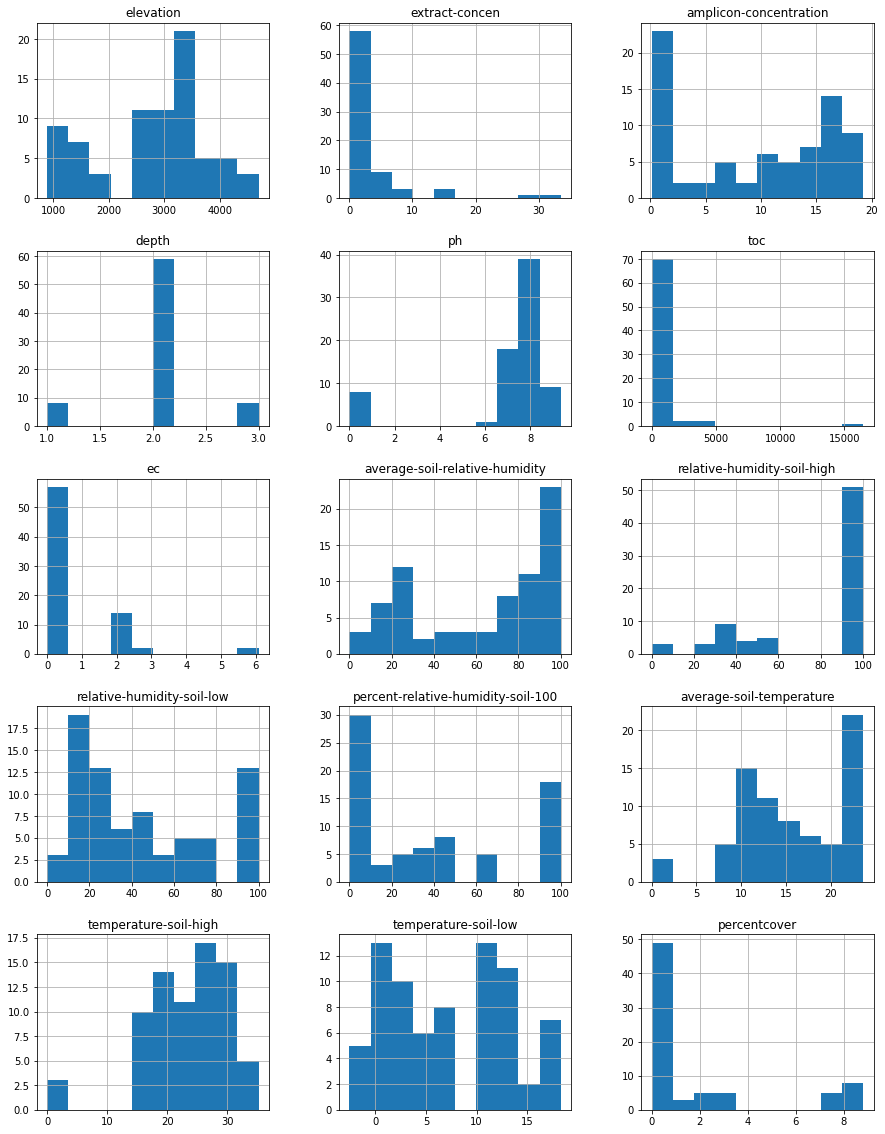

In [9]:
fig, axis = plt.subplots(5,3,figsize=(15, 20))
meta.hist(ax=axis)

# fig.savefig('plots/meta_unscaled.png')

## Scale covariates

In [10]:
scaler = preprocessing.StandardScaler().fit(meta)
meta_scaled = scaler.transform(meta)

meta_scaled = pd.DataFrame(meta_scaled, index=meta.index, columns=meta.columns)
meta_scaled.head()

,elevation,extract-concen,amplicon-concentration,depth,ph,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
sample-id,,,,,,,,,,,,,,,
BAQ1370.1.2,-1.444382,-0.491764,-1.270117,0.000000,0.368754,-0.086769,4.271529,-1.413475,-1.710932,-0.994979,-0.966304,1.196256,1.711718,0.882451,-0.602138
BAQ1370.3,-1.444382,-0.474017,1.171543,0.000000,-2.802209,0.039684,4.271529,-1.413475,-1.710932,-0.994979,-0.966304,1.196256,1.711718,0.882451,-0.602138
BAQ1370.1.3,-1.444382,-0.292154,-1.268638,2.165064,0.428358,-0.356639,-0.574897,-1.413475,-1.710932,-0.994979,-0.966304,1.196256,1.711718,0.882451,-0.602138
BAQ1552.1.1,-1.263727,-0.372945,1.374152,-2.165064,0.325044,-0.356639,-0.574897,-1.426080,-1.353652,-1.004866,-0.966304,1.199730,1.038703,0.628925,-0.602138
BAQ1552.2,-1.263727,-0.492102,-1.114832,0.000000,-2.802209,-0.242008,0.890988,-1.426080,-1.353652,-1.004866,-0.966304,1.199730,1.038703,0.628925,-0.602138


array([<AxesSubplot:title={'center':'elevation'}>,
       <AxesSubplot:title={'center':'extract-concen'}>,
       <AxesSubplot:title={'center':'amplicon-concentration'}>,
       <AxesSubplot:title={'center':'depth'}>,
       <AxesSubplot:title={'center':'ph'}>,
       <AxesSubplot:title={'center':'toc'}>,
       <AxesSubplot:title={'center':'ec'}>,
       <AxesSubplot:title={'center':'average-soil-relative-humidity'}>,
       <AxesSubplot:title={'center':'relative-humidity-soil-high'}>,
       <AxesSubplot:title={'center':'relative-humidity-soil-low'}>,
       <AxesSubplot:title={'center':'percent-relative-humidity-soil-100'}>,
       <AxesSubplot:title={'center':'average-soil-temperature'}>,
       <AxesSubplot:title={'center':'temperature-soil-high'}>,
       <AxesSubplot:title={'center':'temperature-soil-low'}>,
       <AxesSubplot:title={'center':'percentcover'}>], dtype=object)

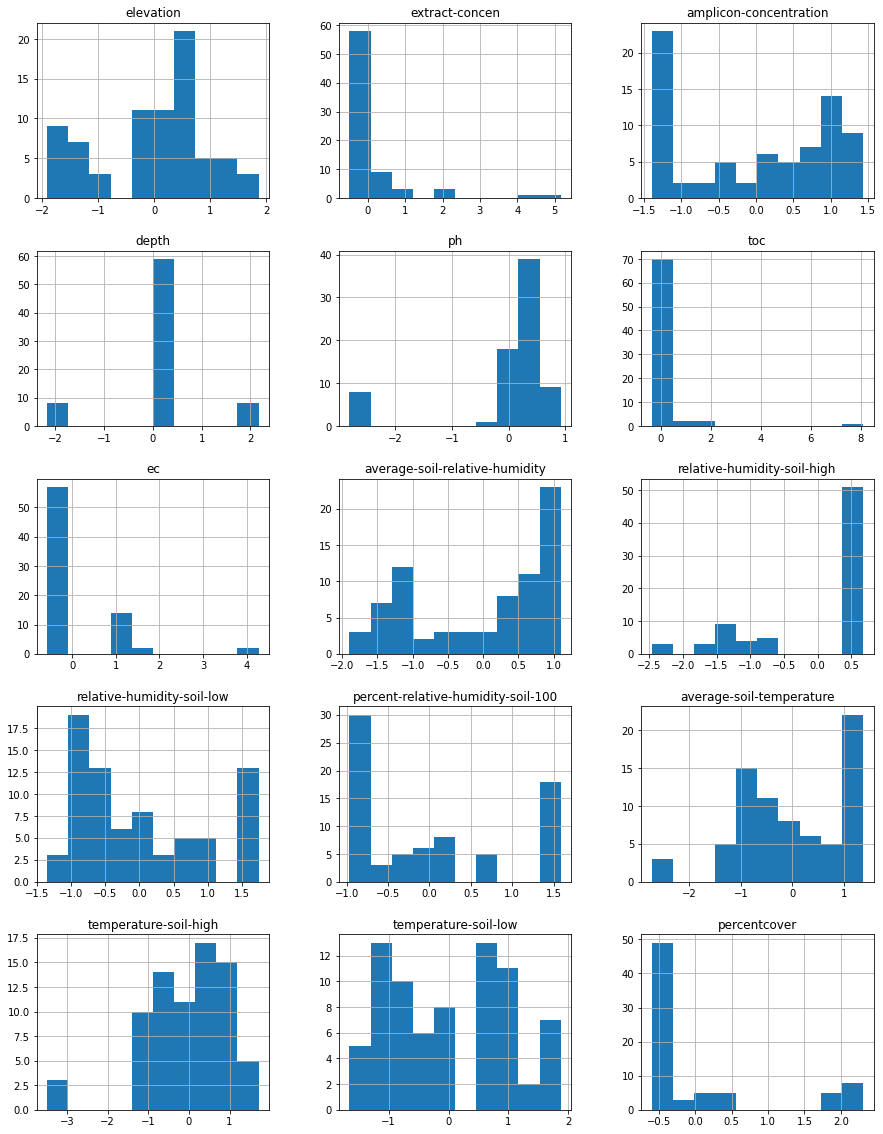

In [11]:
fig, axis = plt.subplots(5,3,figsize=(15, 20))
meta_scaled.hist(ax=axis)

# fig.savefig('plots/meta_scaled.png')

## Merge data with covariates

In [12]:
# # transpose count data
# mclr_T = mclr.T
# # join by sample id
# df = mclr_T.join(meta_scaled)

# transpose count data
clr_T = clr.T
# join by sample id
df = clr_T.join(meta_scaled)

#check if any missing values
print("Any missing values?: {0}".format(df.isnull().sum().any()))
print(df.shape)
df.head()

Any missing values?: False
(53, 145)


,409faa5f5353e543bf6d99125c7c0e83,1237d5925a7176fced9dda961a86c684,a7b877ae6d2f079a15b6b192a4425620,ef3fdbe1dcde754d91130cde6a4b4d61,96cbccca68ad868a78bb0604e4a41cf5,11f7b172e09b77715d3bb2175a40b409,1694836fc379411d2b9aa087d68d571b,a36b38f754f6abd278aeb9dbc7696343,ffd60d684f32e6fd5b47fe90095f9d34,c6a6705874a49360a01c2b3fd39fe900,...,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
BAQ2420.1.1,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,4.559617,-0.167770,-0.167770,...,-0.356639,-0.574897,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.1.2,-0.436407,-0.436407,-0.436407,2.782469,-0.436407,2.271643,-0.436407,-0.436407,-0.436407,-0.436407,...,-0.271309,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.1.3,-0.229753,1.967471,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,...,-0.356639,-0.574897,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.2,-0.424645,4.097143,3.264234,-0.424645,-0.424645,2.907559,-0.424645,-0.424645,-0.424645,-0.424645,...,-0.183408,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.3,-0.353991,-0.353991,3.558032,-0.353991,-0.353991,2.418598,-0.353991,3.407209,-0.353991,-0.353991,...,-0.061582,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138


In [13]:
# Rename long feature IDs with concise names
vis_df = df.copy()
id_dict = dict()

i = 1
for col in vis_df.columns:
    # length of ASVs identifier
    if len(col) == 32:
        asv_name = "ASV_{0}".format(i)
        id_dict[asv_name] = col
        vis_df.rename(columns={col: asv_name}, inplace=True)
        
        i += 1

In [14]:
vis_df.head()

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
BAQ2420.1.1,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,-0.167770,4.559617,-0.167770,-0.167770,...,-0.356639,-0.574897,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.1.2,-0.436407,-0.436407,-0.436407,2.782469,-0.436407,2.271643,-0.436407,-0.436407,-0.436407,-0.436407,...,-0.271309,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.1.3,-0.229753,1.967471,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,-0.229753,...,-0.356639,-0.574897,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.2,-0.424645,4.097143,3.264234,-0.424645,-0.424645,2.907559,-0.424645,-0.424645,-0.424645,-0.424645,...,-0.183408,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138
BAQ2420.3,-0.353991,-0.353991,3.558032,-0.353991,-0.353991,2.418598,-0.353991,3.407209,-0.353991,-0.353991,...,-0.061582,-0.515113,0.578402,0.673964,-0.076802,0.227264,1.168465,0.691421,1.023412,-0.602138


## Covariance

In [15]:
n_cov = meta_scaled.shape[1]
asv = df.iloc[:, :-n_cov]
S = np.cov(asv.T.values, bias=True)

# correlation between ASVs ONLY
corr = scale_array_by_diagonal(S)

asv_names = vis_df.iloc[:, :-n_cov].columns
vis_S = pd.DataFrame(corr, columns=asv_names, index=asv_names)
print(vis_S.shape)
vis_S.head()

(130, 130)


,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_121,ASV_122,ASV_123,ASV_124,ASV_125,ASV_126,ASV_127,ASV_128,ASV_129,ASV_130
ASV_1,1.000000,0.235220,-0.300181,0.125571,0.179510,-0.038352,0.017890,-0.245254,-0.155529,-0.149668,...,0.438898,0.504847,-0.195431,-0.114226,-0.127345,-0.181318,-0.192322,-0.018626,0.073116,-0.159134
ASV_2,0.235220,1.000000,0.115052,-0.113347,0.271909,-0.096653,-0.193164,-0.165456,-0.200931,-0.058737,...,0.720405,0.531381,0.180252,-0.080613,-0.094829,0.333577,-0.147450,-0.149192,0.061652,-0.119690
ASV_3,-0.300181,0.115052,1.000000,-0.177694,-0.238362,0.148623,-0.214250,0.323172,-0.064146,0.277089,...,-0.125576,-0.185793,0.153479,-0.023443,-0.034526,0.420531,-0.117474,-0.098907,0.141218,-0.079335
ASV_4,0.125571,-0.113347,-0.177694,1.000000,0.146477,0.120237,0.127034,-0.316576,0.229645,0.066499,...,0.101542,-0.030321,-0.141483,-0.130383,0.081982,-0.238298,-0.081075,-0.225834,0.141583,0.036861
ASV_5,0.179510,0.271909,-0.238362,0.146477,1.000000,-0.234617,0.462486,-0.190860,0.251317,-0.204029,...,0.442808,0.297917,-0.163554,-0.097192,-0.111191,-0.154218,-0.165839,-0.166289,-0.151280,-0.136978


In [183]:
fig = px.imshow(vis_S, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Correlation: ASVs', title_x=0.5)

fig.write_image("plots/asv_correlation.png")

In [17]:
S_meta = np.cov(df.T.values, bias=True)

# correlation between ASVs and covariates
corr_meta = scale_array_by_diagonal(S_meta)

vis_S_meta = pd.DataFrame(corr_meta, columns=vis_df.columns, index=vis_df.columns)
print(vis_S_meta.shape)
vis_S_meta.head()

(145, 145)


,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
ASV_1,1.000000,0.235220,-0.300181,0.125571,0.179510,-0.038352,0.017890,-0.245254,-0.155529,-0.149668,...,-0.015090,-0.195793,0.371918,0.234226,0.444960,0.408550,-0.241203,-0.122047,-0.332960,0.405968
ASV_2,0.235220,1.000000,0.115052,-0.113347,0.271909,-0.096653,-0.193164,-0.165456,-0.200931,-0.058737,...,-0.079408,-0.071155,0.148999,0.157698,0.145486,0.074563,0.148470,0.169064,0.118632,0.176022
ASV_3,-0.300181,0.115052,1.000000,-0.177694,-0.238362,0.148623,-0.214250,0.323172,-0.064146,0.277089,...,-0.114919,0.129893,-0.268304,-0.016107,-0.346333,-0.384251,0.483882,0.406012,0.513976,-0.358781
ASV_4,0.125571,-0.113347,-0.177694,1.000000,0.146477,0.120237,0.127034,-0.316576,0.229645,0.066499,...,0.190914,-0.072707,0.024088,0.003441,0.032218,0.019654,-0.372550,-0.339999,-0.350075,0.014423
ASV_5,0.179510,0.271909,-0.238362,0.146477,1.000000,-0.234617,0.462486,-0.190860,0.251317,-0.204029,...,-0.061404,-0.170493,-0.272803,-0.475548,-0.002371,0.028204,-0.555721,-0.664579,-0.359112,0.261146


In [184]:
fig = px.imshow(vis_S_meta, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Covariance: ASVs and covariates', title_x=0.5)

fig.write_image("plots/asv_and_covariates_correlation.png")

# Models

In [19]:
N = asv.shape[0]
p = asv.shape[1]
print("Shape of data without covariates: {0}, {1}".format(N, p))

N_meta = df.shape[0]
p_meta = df.shape[1]
print("Shape of data with covariates: {0}, {1}".format(N_meta, p_meta))

Shape of data without covariates: 53, 130
Shape of data with covariates: 53, 145


**Statement 1**:

We know that environment has a large impact on microbial composition.
We would like to investigate this effect and run single graphical lasso model while accounting for latent components.

## SGL + low-rank

In [20]:
lambda1_range = np.logspace(0, -4, 15)
mu1_range = np.logspace(2, -1, 10)

modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

In [21]:
P_SGL_low = glasso_problem(corr, N, latent=True, do_scaling=False)
print(P_SGL_low)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [22]:
P_SGL_low.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1)
print(P_SGL_low.reg_params)

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 76 iterations with status: optimal.
ADMM terminated after 158 iterations with status: optimal.
ADMM terminated after 293 iterations with status: optimal.
ADMM terminated after 70 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM termina

In [23]:
for stat in ['AIC', 'SP', 'RANK', 'LAMBDA', 'MU', 'BEST']:
    print(stat)
    print(P_SGL_low.modelselect_stats[stat])

AIC
[[  6890.00000059   6890.00000059   6890.00000059   6890.32232636
    6985.34719181   7633.32391953  10648.47423608  19443.65329884
   42354.68686262  96734.9299959 ]
 [  5341.39537068   5341.38425673   5341.38425665   5357.71218735
    5923.2845434    7019.34226264  10592.83809709  19443.64981956
   42354.66292287  96733.13128484]
 [  3199.56448478   3200.24245705   3200.24121702   3200.24120225
    3398.5652758    4929.18436202   9115.36625752  19349.14089526
   42354.27266456  96733.09945687]
 [  1758.64830533   1758.62008696   1758.62222349   1758.62251856
    1758.622557     2009.14089544   5333.20828058  16456.07933952
   42321.83751383  96733.2637976 ]
 [   125.70060352    126.75348782    125.9339755     126.08057847
     126.17435157    126.25450162    810.10040897   9113.43956776
   37637.99239296  96734.64475564]
 [ -1442.07030944  -1437.62123632  -1436.88259948  -1437.07275798
   -1437.21591784  -1437.34217154  -1439.36156826    539.90802921
   22312.60618738  90658.7528

In [185]:
precision_SGL_low = pd.DataFrame(P_SGL_low.solution.precision_, columns=asv_names, index=asv_names)

fig = px.imshow(precision_SGL_low, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Negative inverse covariance: ASVs', title_x=0.5)

fig.write_image("plots/sgl_asv_only.png")

In [25]:
L = pd.DataFrame(P_SGL_low.solution.lowrank_, columns=asv_names, index=asv_names)

print("Rank: {0}".format(np.linalg.matrix_rank(L)))

Rank: 3


**Statement 2**:

According to the models selection statistics, the chosen optimal hyperparameters lay in the middle of the grid and we have reached a global minimum of our function. Yet we can try to find such hyperparameters which give us low-rank solutions with the rank of our interest, e.g., from 0 to 10 as well as desired data sparsity level.

In [26]:
lambda1_range = [0.07]
mu1_range = [1.8, 1.55, 1.4, 1.2, 1.18, 1.1, 1.09, 1.05, 1.015, 1]

modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

In [27]:
P_SGL_low_tuned = glasso_problem(corr, N, latent=True, do_scaling=False)
print(P_SGL_low_tuned)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [28]:
P_SGL_low_tuned.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1)
print(P_SGL_low_tuned.reg_params)

ADMM terminated after 204 iterations with status: optimal.
ADMM terminated after 75 iterations with status: optimal.
ADMM terminated after 73 iterations with status: optimal.
ADMM terminated after 90 iterations with status: optimal.
ADMM terminated after 71 iterations with status: optimal.
ADMM terminated after 68 iterations with status: optimal.
ADMM terminated after 66 iterations with status: optimal.
ADMM terminated after 66 iterations with status: optimal.
ADMM terminated after 65 iterations with status: optimal.
ADMM terminated after 64 iterations with status: optimal.
{'lambda1': 0.07, 'mu1': 1.0}


In [29]:
for stat in ['AIC', 'SP', 'RANK', 'MU', 'BEST']:
    print(stat)
    print(P_SGL_low_tuned.modelselect_stats[stat])

AIC
[[ 63.74643349  82.23038202 122.31177342 254.21698791 271.91677478
  388.99469534 414.14668045 508.07229434 604.90707751 650.9159151 ]]
SP
[[0.23744782 0.23375075 0.22826476 0.21550388 0.21347645 0.20691711
  0.20655933 0.20178891 0.19737627 0.19534884]]
RANK
[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
MU
[[1.8   1.55  1.4   1.2   1.18  1.1   1.09  1.05  1.015 1.   ]]
BEST
{'lambda1': 0.07, 'mu1': 1.0}


In [105]:
L_tuned = pd.DataFrame(P_SGL_low_tuned.solution.lowrank_, columns=asv_names, index=asv_names)

rank = np.linalg.matrix_rank(L_tuned)
print("Rank: {0}".format(rank))

Rank: 10


In [187]:
fig = px.imshow(L_tuned, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Low-rank: ASVs', title_x=0.5)

fig.write_image("plots/low_rank_asv_only.png")

**Statement 3**:

Imagine we don't have covariate information.

The Graphical Lasso solution is of the form Θ−𝐿 where Θ is sparse and 𝐿 has low rank. We use the low rank component of the Graphical Lasso solution in order to do a robust PCA. For this, we use the eigendecomposition 𝐿=𝑉Σ𝑉𝑇 where the columns of 𝑉 are the orthonormal eigenvecors and Σ is diagonal containing the eigenvalues. Denote the columns of 𝑉 corresponding only to positive eigenvalues with 𝑉̃ ∈ℝ𝑝×𝑟 and Σ̃ ∈ℝ𝑟×𝑟 accordingly, where 𝑟=rank(𝐿). Then we have 𝐿=𝑉̃ Σ̃ 𝑉̃ 𝑇.
Now we project the data matrix 𝑋∈ℝ𝑝×𝑁 onto the eigenspaces of 𝐿−1 - which are the same as of 𝐿 - by computing:

In [32]:
proj, loadings, eigv = PCA(asv, L_tuned, inverse=True)

In [33]:
depth = raw.sum(axis=0)
ph = vis_df["ph"]

Spearman correlation between pH and 1st component: 0.5296990056034171, p-value: 4.5294001965676764e-05


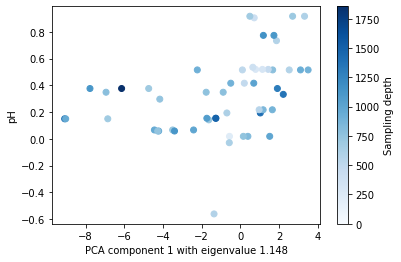

In [34]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

fig, ax = plt.subplots(1,1)
im = ax.scatter(proj[:,0], ph, c = depth, cmap = plt.cm.Blues, vmin = 0)
cbar = fig.colorbar(im)
cbar.set_label("Sampling depth")
ax.set_xlabel(f"PCA component 1 with eigenvalue {eigv[0]}")
ax.set_ylabel("pH")

print("Spearman correlation between pH and 1st component: {0}, p-value: {1}".format(stats.spearmanr(ph, proj[:,0])[0],
                                                                              stats.spearmanr(ph, proj[:,0])[1]))


**Statement 4**:

Alternatively, we could solve SGL with adaptive penalization and covariance matrix where covariates are included. So, we could see if loading vectors of PCA we found with the previous model where was no information about covariates are correlated with the solution where we include covariate information. Thus, we could argue that SGL model with low-rank component can capture the information which is unknown but important for microbial composition.

## SGL with covariates and adaptive penalization procedure

In [35]:
# create lambda matrix full of zeros
shape_meta = (p_meta, p_meta)
mask = np.zeros(shape_meta)

# add small constant, so ADMM could converge
mask = mask + 0.01

# heavy penalize species
n_bugs = len(asv.columns)
bugs_block = np.ones((n_bugs, n_bugs))
mask[0:n_bugs, 0:n_bugs] += bugs_block - 0.01
lambda1_mask_exp = mask

In [36]:
lambda1_mask_exp.shape

(145, 145)

In [188]:
df_mask_exp = pd.DataFrame(lambda1_mask_exp, columns=vis_df.columns, index=vis_df.columns)

fig = px.imshow(df_mask_exp, color_continuous_scale='RdBu_r')
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Lambda-mask matrix: weights before the penalization term', title_x=0.5)

fig.add_annotation(text="$\lambda=1$",
                  xref="paper", yref="paper", font=dict(color='yellow',size=155),
                  x=0.5, y=0.5, showarrow=False)
fig.add_annotation(text="$\lambda=0.01$",
                  xref="paper", yref="paper", font=dict(color='yellow',size=155),
                  x=0.5, y=0.05, showarrow=False)

fig.update_coloraxes(showscale=False)

fig.write_image("plots/lambda_mask.png")

In [189]:
### the same default grid, no tuning
lambda1_range = np.logspace(0, -4, 15)

### less sparsity in ASVs block
# lambda1_range = np.logspace(-0.5, -1, 15)

modelselect_params = {'lambda1_range': lambda1_range, 'lambda1_mask': lambda1_mask_exp}

In [166]:
P_SGL_adapt = glasso_problem(corr_meta, N_meta, latent=False, do_scaling=False)
print(P_SGL_adapt)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': None, 'mu1': None}


In [167]:
P_SGL_adapt.model_selection(modelselect_params=modelselect_params, method='eBIC', gamma=0.1)
print(P_SGL_adapt.reg_params)

ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: max iterations reached.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status

Note: mu1=0, i.e., no low-rank

In [169]:
for stat in ['AIC', 'SP', 'LAMBDA', 'BEST']:
    print(stat)
    print(P_SGL_adapt.modelselect_stats[stat])

AIC
[[  4872.08010825]
 [  4404.05411385]
 [  2713.16907944]
 [   868.12277961]
 [  -867.82066753]
 [ -2746.93244637]
 [ -4970.55408134]
 [ -7266.15856597]
 [ -9647.66714873]
 [-12048.85075509]
 [-14413.35932256]
 [-16235.90639179]
 [-17890.288427  ]
 [-19623.11944899]
 [-21305.8889021 ]]
SP
[[0.1493295 ]
 [0.17260536]
 [0.19846743]
 [0.26082375]
 [0.35019157]
 [0.44176245]
 [0.51111111]
 [0.57471264]
 [0.62749042]
 [0.66340996]
 [0.69214559]
 [0.726341  ]
 [0.76072797]
 [0.79128352]
 [0.82155172]]
LAMBDA
[[1.00000000e+00]
 [5.17947468e-01]
 [2.68269580e-01]
 [1.38949549e-01]
 [7.19685673e-02]
 [3.72759372e-02]
 [1.93069773e-02]
 [1.00000000e-02]
 [5.17947468e-03]
 [2.68269580e-03]
 [1.38949549e-03]
 [7.19685673e-04]
 [3.72759372e-04]
 [1.93069773e-04]
 [1.00000000e-04]]
BEST
{'lambda1': 0.2682695795279726, 'mu1': 0}


In [170]:
precision_adapt = pd.DataFrame(P_SGL_adapt.solution.precision_, columns=vis_df.columns, index=vis_df.columns)
precision_adapt.head()

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,toc,ec,average-soil-relative-humidity,relative-humidity-soil-high,relative-humidity-soil-low,percent-relative-humidity-soil-100,average-soil-temperature,temperature-soil-high,temperature-soil-low,percentcover
ASV_1,1.381197,-0.000000,0.000000,-0.000000,-0.00000,0.0,-0.0,0.0,0.0,0.0,...,0.060287,0.093950,-0.130109,-0.046727,-0.689265,0.290535,0.504901,-0.000000,-0.024121,0.001000
ASV_2,-0.000000,1.559589,-0.000000,0.000000,-0.00000,0.0,-0.0,0.0,0.0,0.0,...,0.111814,0.176151,-0.813182,0.000000,-0.241194,1.266040,0.000000,0.399321,-0.360620,-0.652868
ASV_3,0.000000,-0.000000,1.633819,0.000000,0.00000,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.040834,0.132636,1.979257,-0.835965,-0.793672,0.000000,-0.456673,-0.444588,-0.526326,0.155079
ASV_4,-0.000000,0.000000,0.000000,1.477703,-0.00000,-0.0,0.0,0.0,0.0,-0.0,...,-0.122476,-0.010029,0.043530,-0.307425,-0.411381,0.694244,0.404808,-0.000000,0.000000,0.287952
ASV_5,-0.000000,-0.000000,0.000000,-0.000000,3.31299,0.0,0.0,0.0,0.0,0.0,...,0.208545,0.542542,-0.497756,0.169746,0.039364,1.949311,0.878655,2.896176,-1.452017,-2.462432


In [191]:
fig = px.imshow(precision_adapt, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 1000, height = 1000,
                 title='Negative inverse covariance (adaptive)', title_x=0.5)
fig.write_image("plots/sgl_asv_and_cov.png")

In [192]:
inv_cov = precision_adapt.iloc[:-n_cov, -n_cov:]

fig = px.imshow(inv_cov, color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
fig.update_layout(margin = dict(t=100,r=100,b=100,l=100), width = 600, height = 3000,
                 title='Negative inverse covariance between ASVs and covariates', title_x=0.5)

fig.write_image("plots/sgl_cov.png")

Spearman correlation between estimated pH and 9th principal axis: 0.41182921297154346, 
	 p-value: 1.1271611852557354e-06


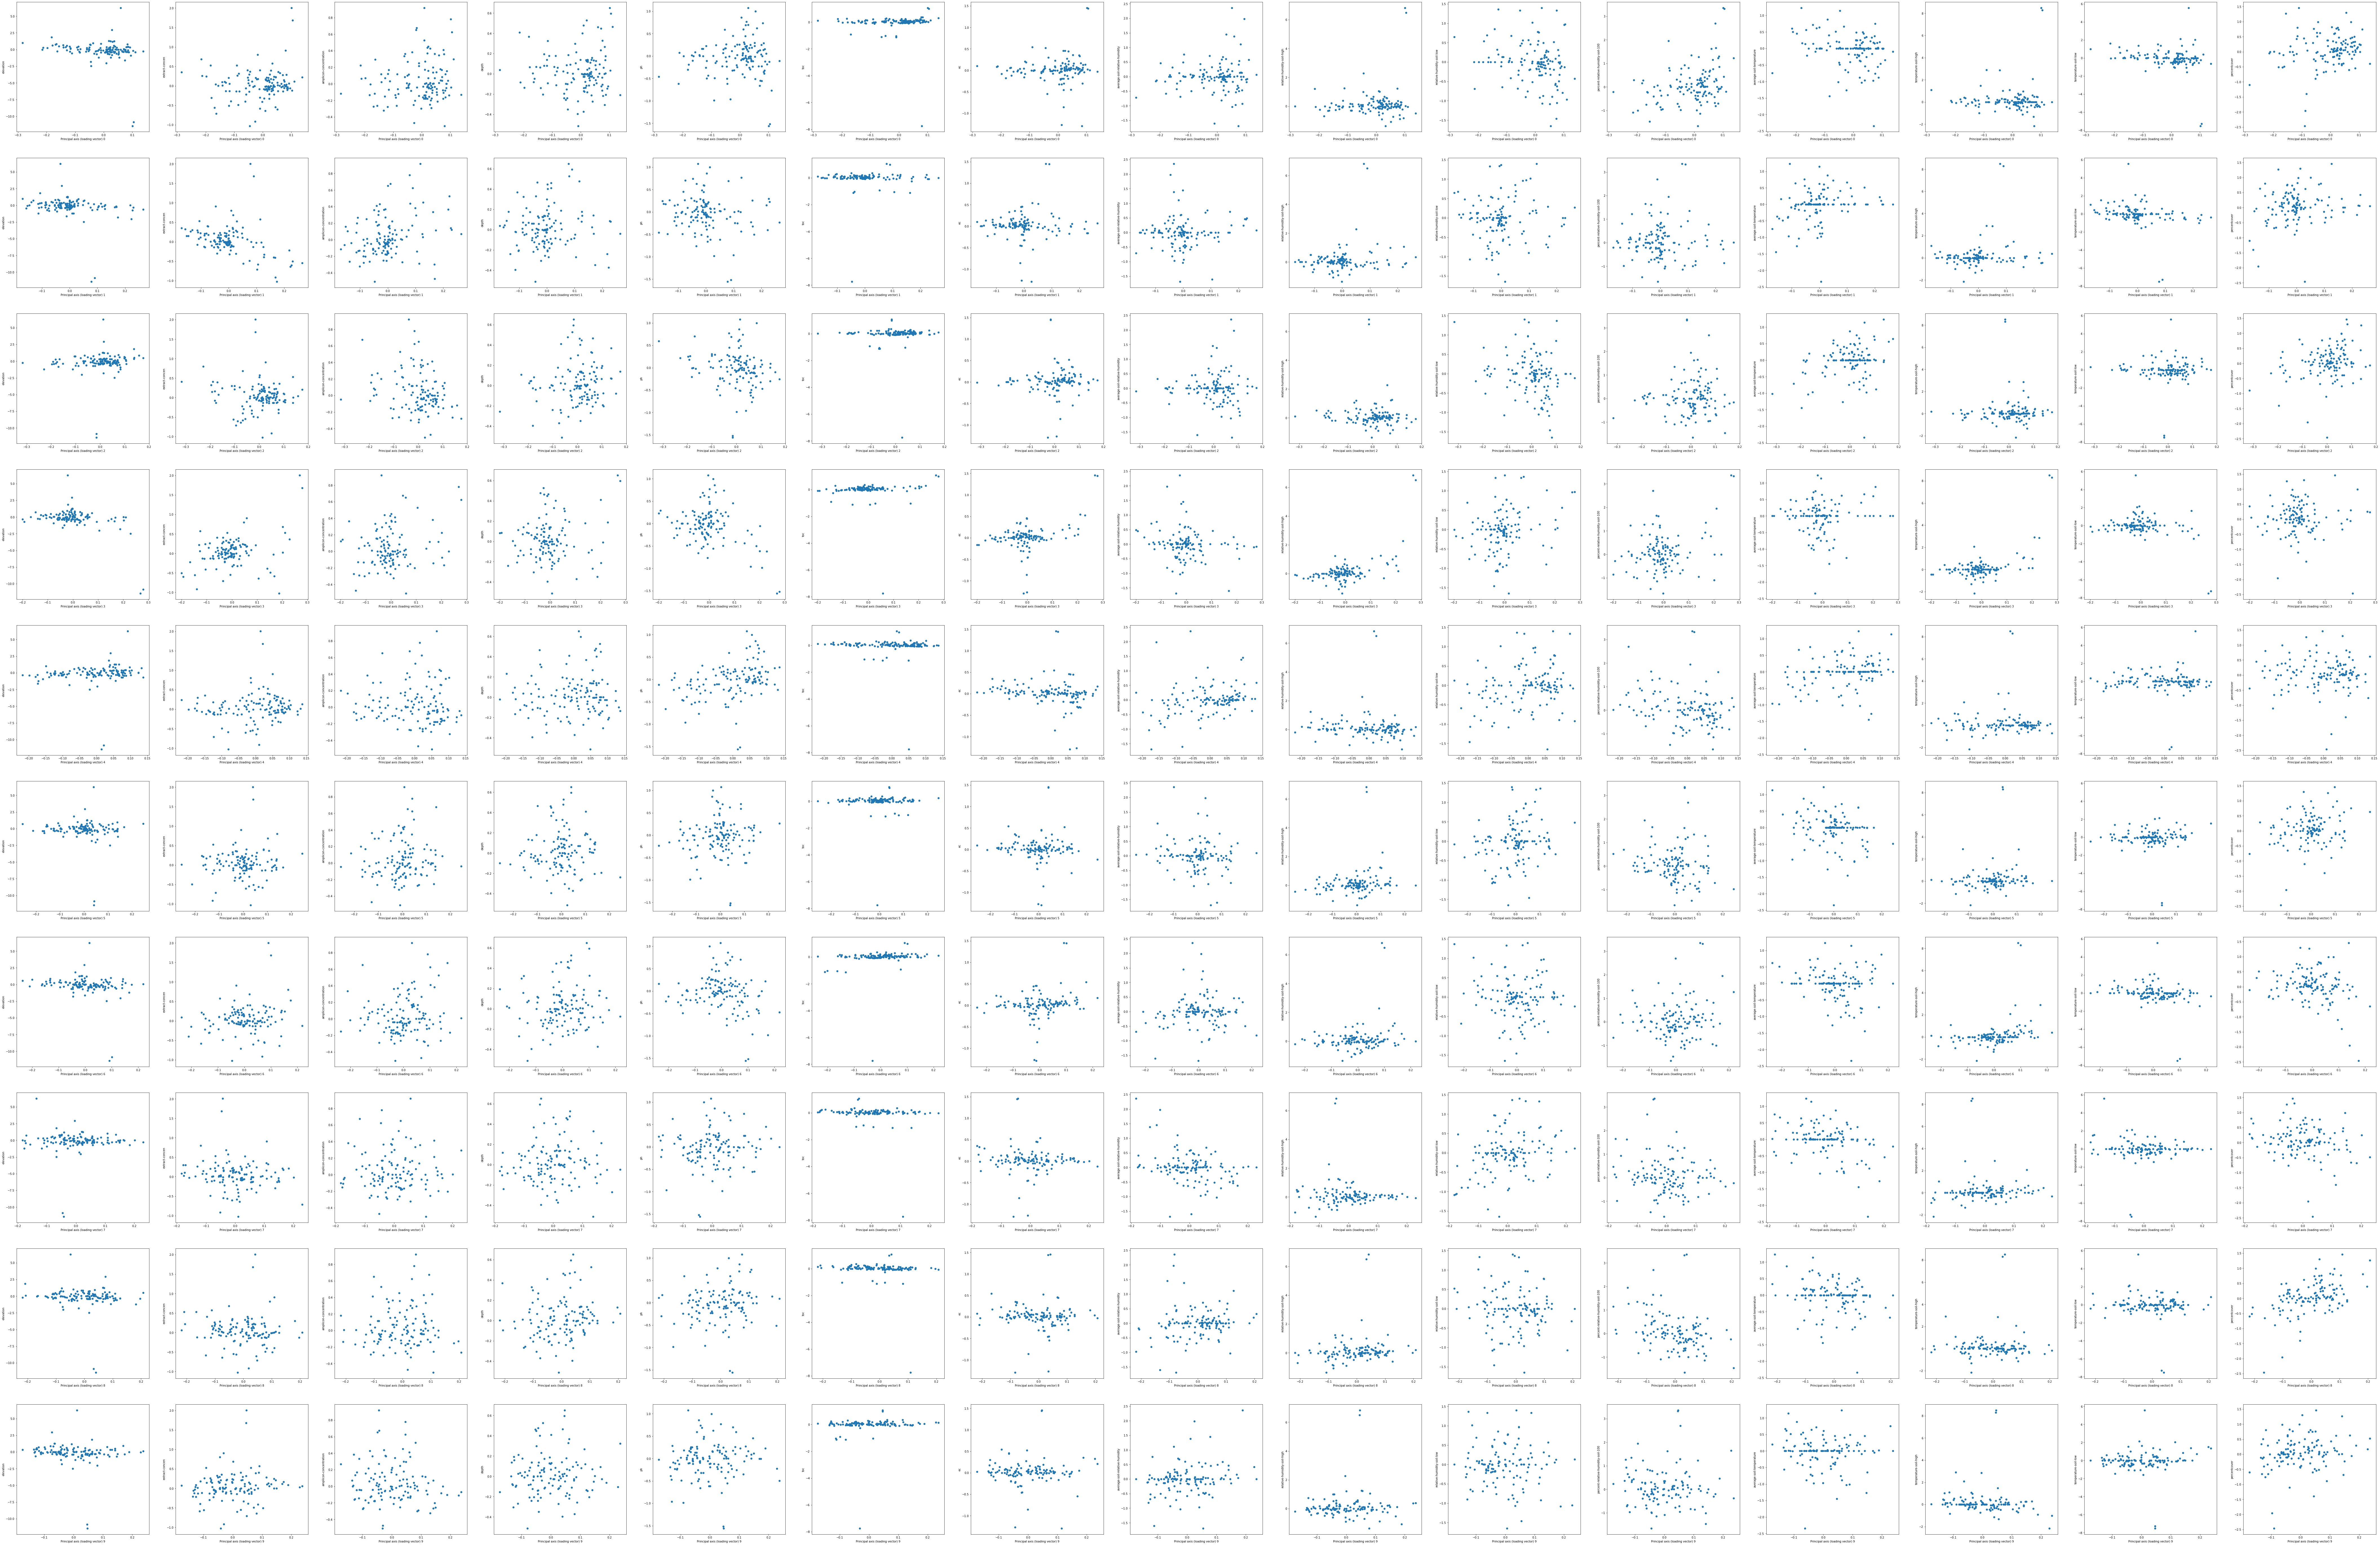

In [244]:
fig, ax = plt.subplots(10, 15, figsize=(150, 100))

j = 0
for col in inv_cov.columns:

    for i in range(0, rank):
        spearman_r = stats.spearmanr(inv_cov[col], loadings[:, i])
        if abs(spearman_r[0]) > 0.4:
            print("Spearman correlation between estimated pH and {0}th principal axis: {1}, \n\t p-value: {2}".format(
            axis, spearman_r[0], spearman_r[1]))
            
        
        ax[i][j].scatter(loadings[:,i], inv_cov[col])
        ax[i][j].set_xlabel("Principal axis (loading vector) {0}".format(i))
        ax[i][j].set_ylabel("{0}".format(col))

#         # Hide x labels and tick labels for top plots and y ticks for right plots.
#         for a in ax.flat:
#             a.label_outer()
        
    j += 1
    
plt.savefig("plots/big_scatter.png")